## Load YaleB data
## Extract DSIFT features

In [1]:
import img2matrix
import numpy as np

yaleb = img2matrix.batch_convert_YaleB(truncate_num=38, images_per_person=None)

train_image = yaleb[0][0]
train_label = yaleb[0][1]
test_image = yaleb[1][0]
test_label = yaleb[1][1]
img_size = yaleb[2]

images_full = train_image #np.concatenate([train_image, test_image])
labels = train_label #np.concatenate([train_label, test_label])

images_raw = images_full[:, :32256]
images_dsift = images_full[:, 32256:]
print(images_raw.shape)
print(images_dsift.shape)

KeyboardInterrupt: 

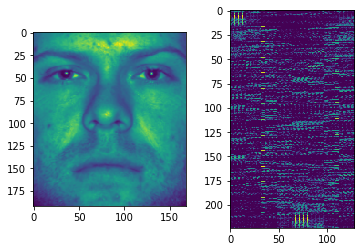

In [127]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)

#imgplot = plt.imshow(images_dsift[0].reshape((18, 64)))
ax[0].imshow(images_raw[0].reshape((-1, 168)));
ax[1].imshow(images_dsift[0].reshape((-1, 128)));

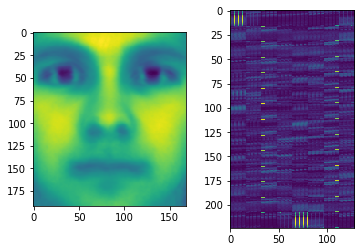

In [128]:
fig, ax = plt.subplots(1, 2)

#imgplot = plt.imshow(np.mean(images_dsift, axis=0).reshape((18, 64)))
ax[0].imshow(np.mean(images_raw, axis=0).reshape((-1, 168)));
ax[1].imshow(np.mean(images_dsift, axis=0).reshape((-1, 128)));

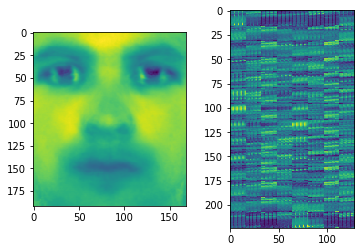

In [6]:
fig, ax = plt.subplots(1, 2)

#imgplot = plt.imshow(np.std(images_dsift, axis=0).reshape((18, 64)))
ax[0].imshow(np.std(images_raw, axis=0).reshape((-1, 168)));
ax[1].imshow(np.std(images_dsift, axis=0).reshape((-1, 128)));

## Perform PCA

In [130]:
from sklearn.decomposition import PCA
import numpy as np
    
pca = PCA(n_components=300, whiten=False, svd_solver='arpack', random_state=0)
#images_pca = pca.fit_transform(np.concatenate((1*images_raw, 10*images_dsift), axis=1))
images_pca = pca.fit_transform(images_dsift)

images_pca.shape

(2350, 300)

In [1]:
from scipy.io import loadmat, savemat

images_hm2 = loadmat('./../1-DSCwSP/HM2/YaleB.mat')['HM2']

images_hm2.shape

(2350, 150)

In [104]:
from scipy.io import loadmat, savemat

labels_pred = loadmat('./../1-DSCwSP/Labels_pred/YaleB.mat')['grps'][:, 0]

In [2]:
from sklearn.manifold import TSNE

tsne = TSNE()
#images_tsne = tsne.fit_transform(images_pca)
images_tsne = tsne.fit_transform(images_hm2)

In [3]:
import matplotlib.pyplot as plt

plt.scatter(images_tsne[:, 0], images_tsne[:, 1], c=labels)
plt.show()

NameError: name 'labels' is not defined

In [ ]:
tsne2 = TSNE(n_components=3)
#images_tsne2 = tsne2.fit_transform(images_pca)
images_tsne2 = tsne2.fit_transform(images_hm2)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
from IPython.display import HTML

fig = plt.figure()
ax = Axes3D(fig)
scatter = ax.scatter(images_tsne2[:, 0], images_tsne2[:, 1], images_tsne2[:, 2], c=labels)

def init():
    return (scatter,)

def animate(angle):
    ax.view_init(30, 2*angle)
    return (scatter,)
    
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=180, interval=40, blit=True)

In [ ]:
HTML(anim.to_html5_video())

In [5]:
def display_image(image):
    print(np.min(image), np.max(image))
    imgplot = plt.imshow(image.reshape((10, 30)))

-2.4952768681340927 3.9265003715192783


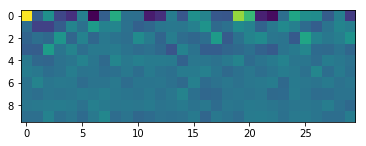

In [7]:
import matplotlib.pyplot as plt

# these are reduced parameters - not supposed to look like anything
display_image(images_pca[0])

-4.346405032575081e-16 4.822619844839829e-16


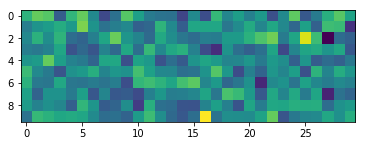

In [8]:
display_image(np.mean(images_pca, axis=0))

0.2566093011920059 2.6429238293260684


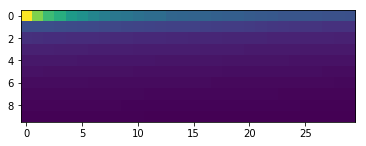

In [9]:
display_image(np.std(images_pca, axis=0))

In [141]:
from scipy.io import savemat

savemat('./PCA/YaleB.mat', mdict={'X': images_pca, 'Y': labels})

## Normalize PCA output

In [2]:
import numpy as np
from scipy.io import loadmat

loaded = loadmat('./PCA/YaleB.mat')
images_pca = loaded['X'];
labels = loaded['Y'];

In [84]:
# Types:
# feature-wise - normalization occurs along one pixel of all images
# image-wise - normalization occurs along all pixels of one image
# all - normalization occurs along all pixels of all images

# Methods:
# standard - mean is set to 0, std is set to 1
# [-1, 1] - min and max are used to linearly change the data range to [-1, 1]
# unit-vector - each bin is divided by its euclidean distance

#[BAD] feature, standard
#images_norm = (images_pca - np.mean(images_pca, axis=0)) / np.std(images_pca, axis=0)
# image, standard
#images_norm = (images_pca - np.mean(images_pca, axis=1)[:, np.newaxis]) / np.std(images_pca, axis=1)[:, np.newaxis]
# all, standard
#images_norm = (images_pca - np.mean(images_pca)) / np.std(images_pca)


#[BAD] feature, [-1, 1]
#mmin = np.min(images_pca, axis=0)
#mmax = np.max(images_pca, axis=0)
#[BAD] image, [-1, 1]
#mmin = np.min(images_pca, axis=1)[:, np.newaxis]
#mmax = np.max(images_pca, axis=1)[:, np.newaxis]
# all, [-1, 1]
mmin = np.min(images_pca)
mmax = np.max(images_pca)
# FOR ALL:
images_norm = (2*images_pca - mmax - mmin) / (mmax - mmin)

#[BAD] feature, unit
#images_norm = images_pca / np.sqrt(np.sum(images_pca*images_pca, axis=0))
# image, unit
#images_norm = images_pca / np.sqrt(np.sum(images_pca*images_pca, axis=1))[:, np.newaxis]
# all, unit
#images_norm = images_pca / np.sqrt(np.sum(images_pca*images_pca))

-0.4795362210162537 0.7368686509962333


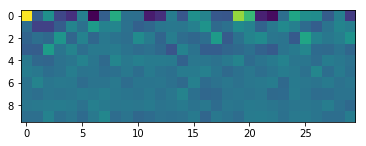

In [85]:
import matplotlib.pyplot as plt

# these are reduced parameters - not supposed to look like anything
display_image(images_norm[0])

-0.006884052286993166 -0.006884052286992992


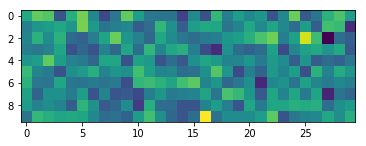

In [86]:
display_image(np.mean(images_norm, axis=0))

0.04860660725605053 0.5006192682142393


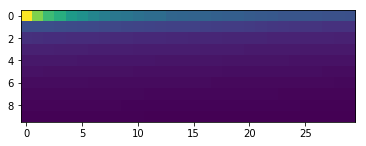

In [87]:
display_image(np.std(images_norm, axis=0))

In [88]:
from scipy.io import savemat

savemat('./PCA_norm/YaleB.mat', mdict={'X': images_norm, 'Y': labels})

## Calculate C matrix

In [2]:
import dsc
from sklearn.datasets import load_boston
from sklearn.preprocessing import scale
import numpy as np
from scipy.io import loadmat, savemat
import sp_blitzl1
import supporting_files.sda as sda

import importlib
importlib.reload(sp_blitzl1)
from sp_blitzl1 import sparseCoefRecovery

from supporting_files.helpers import optimize

In [3]:
#digits = load_boston().data
#digits = scale(digits)
mat = loadmat("./../1-helper/PCA_norm/YaleB.mat")
digits = mat['X']
labels = mat['Y'][0]
#np.random.shuffle(digits)
#digits = digits[:10]
digits.shape

(2350, 300)

In [3]:
# takes a while
C, loss = sparseCoefRecovery(digits.T, l=0.01)
loss

Processed for 0 samples
Processed for 100 samples
Processed for 200 samples
Processed for 300 samples
Processed for 400 samples
Processed for 500 samples
Processed for 600 samples


50562.38807491135

In [7]:
np.sum((np.matmul(digits.T, C) - digits.T) ** 2)

28942.92830336333

In [8]:
np.sum(C ** 2)

353.2543620891577

In [4]:
C = loadmat("./C_mats/YaleB.mat")['C']

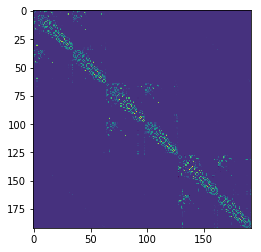

In [6]:
import matplotlib.pyplot as plt
imgplot = plt.imshow(C[:64*3, :64*3])
plt.show()

In [ ]:
savemat('./C_mats/YaleB.mat', mdict={'C': C})

## Train Autoencoder

In [45]:
%%time
importlib.reload(dsc)
importlib.reload(sda)
d = dsc.DeepSubspaceClustering(digits, C=C, hidden_dims=[200, 150, 200], lambda1=0.0001, lambda2=0.001, learning_rate=0.006,
                               weight_init='sda-uniform', weight_init_params=[10001, 0.08, digits.shape[0]],
                               optimizer='Adam', decay='sqrt', sda_optimizer='Adam', sda_decay='sqrt')

Layer 1
300 -> 200
epoch 0: global loss = 1.0853201150894165
epoch 10: global loss = 0.08749968558549881
epoch 20: global loss = 0.05941764637827873
epoch 30: global loss = 0.044608619064092636
epoch 40: global loss = 0.03766566887497902
epoch 50: global loss = 0.0348389595746994
epoch 60: global loss = 0.0334119088947773
epoch 70: global loss = 0.032671455293893814
epoch 80: global loss = 0.032237887382507324
epoch 90: global loss = 0.031968750059604645
epoch 100: global loss = 0.031790297478437424
epoch 110: global loss = 0.03166840597987175
epoch 120: global loss = 0.031582240015268326
epoch 130: global loss = 0.03151930123567581
epoch 140: global loss = 0.03147213160991669
epoch 150: global loss = 0.03143604099750519
epoch 160: global loss = 0.031407780945301056
epoch 170: global loss = 0.03138532489538193
epoch 180: global loss = 0.031367238610982895
epoch 190: global loss = 0.031352449208498
epoch 200: global loss = 0.031340260058641434
epoch 210: global loss = 0.0313300006091594

epoch 1780: global loss = 0.031237585470080376
epoch 1790: global loss = 0.031237564980983734
epoch 1800: global loss = 0.03123752772808075
epoch 1810: global loss = 0.031237507238984108
epoch 1820: global loss = 0.03123747557401657
epoch 1830: global loss = 0.031237445771694183
epoch 1840: global loss = 0.031237419694662094
epoch 1850: global loss = 0.03123738430440426
epoch 1860: global loss = 0.03123735636472702
epoch 1870: global loss = 0.031237320974469185
epoch 1880: global loss = 0.03123730979859829
epoch 1890: global loss = 0.031237272545695305
epoch 1900: global loss = 0.03123725950717926
epoch 1910: global loss = 0.031237229704856873
epoch 1920: global loss = 0.031237198039889336
epoch 1930: global loss = 0.031237173825502396
epoch 1940: global loss = 0.031237145885825157
epoch 1950: global loss = 0.03123711608350277
epoch 1960: global loss = 0.031237082555890083
epoch 1970: global loss = 0.031237060204148293
epoch 1980: global loss = 0.03123703971505165
epoch 1990: global lo

epoch 3540: global loss = 0.031234223395586014
epoch 3550: global loss = 0.031234201043844223
epoch 3560: global loss = 0.031234193593263626
epoch 3570: global loss = 0.03123418055474758
epoch 3580: global loss = 0.031234171241521835
epoch 3590: global loss = 0.031234152615070343
epoch 3600: global loss = 0.031234147027134895
epoch 3610: global loss = 0.031234126538038254
epoch 3620: global loss = 0.03123411536216736
epoch 3630: global loss = 0.031234098598361015
epoch 3640: global loss = 0.031234081834554672
epoch 3650: global loss = 0.031234072521328926
epoch 3660: global loss = 0.03123406693339348
epoch 3670: global loss = 0.031234048306941986
epoch 3680: global loss = 0.031234031543135643
epoch 3690: global loss = 0.031234024092555046
epoch 3700: global loss = 0.031234007328748703
epoch 3710: global loss = 0.031233996152877808
epoch 3720: global loss = 0.031233981251716614
epoch 3730: global loss = 0.031233973801136017
epoch 3740: global loss = 0.03123396821320057
epoch 3750: globa

epoch 5300: global loss = 0.03123241662979126
epoch 5310: global loss = 0.03123241476714611
epoch 5320: global loss = 0.031232398003339767
epoch 5330: global loss = 0.031232386827468872
epoch 5340: global loss = 0.03123256377875805
epoch 5350: global loss = 0.031234825029969215
epoch 5360: global loss = 0.031232986599206924
epoch 5370: global loss = 0.031232640147209167
epoch 5380: global loss = 0.031232431530952454
epoch 5390: global loss = 0.031232375651597977
epoch 5400: global loss = 0.031232338398694992
epoch 5410: global loss = 0.031232329085469246
epoch 5420: global loss = 0.031232312321662903
epoch 5430: global loss = 0.031232303008437157
epoch 5440: global loss = 0.031232304871082306
epoch 5450: global loss = 0.03123229555785656
epoch 5460: global loss = 0.03123229183256626
epoch 5470: global loss = 0.031232284381985664
epoch 5480: global loss = 0.03123229742050171
epoch 5490: global loss = 0.031232425943017006
epoch 5500: global loss = 0.03123464435338974
epoch 5510: global l

epoch 7060: global loss = 0.031231338158249855
epoch 7070: global loss = 0.031231338158249855
epoch 7080: global loss = 0.0312313474714756
epoch 7090: global loss = 0.031231345608830452
epoch 7100: global loss = 0.031231582164764404
epoch 7110: global loss = 0.031234703958034515
epoch 7120: global loss = 0.03123217634856701
epoch 7130: global loss = 0.03123169019818306
epoch 7140: global loss = 0.031231477856636047
epoch 7150: global loss = 0.031231343746185303
epoch 7160: global loss = 0.031231317669153214
epoch 7170: global loss = 0.031231341883540154
epoch 7180: global loss = 0.031232086941599846
epoch 7190: global loss = 0.03123147413134575
epoch 7200: global loss = 0.031231405213475227
epoch 7210: global loss = 0.0312313511967659
epoch 7220: global loss = 0.03123130090534687
epoch 7230: global loss = 0.031231282278895378
epoch 7240: global loss = 0.03123128041625023
epoch 7250: global loss = 0.031231271103024483
epoch 7260: global loss = 0.031231295317411423
epoch 7270: global los

epoch 8820: global loss = 0.03123086504638195
epoch 8830: global loss = 0.031230906024575233
epoch 8840: global loss = 0.031231826171278954
epoch 8850: global loss = 0.03123137727379799
epoch 8860: global loss = 0.031231002882122993
epoch 8870: global loss = 0.031230835244059563
epoch 8880: global loss = 0.031230827793478966
epoch 8890: global loss = 0.031230805441737175
epoch 8900: global loss = 0.03123079426586628
epoch 8910: global loss = 0.031231021508574486
epoch 8920: global loss = 0.031231829896569252
epoch 8930: global loss = 0.031231015920639038
epoch 8940: global loss = 0.031230805441737175
epoch 8950: global loss = 0.031230799853801727
epoch 8960: global loss = 0.031230788677930832
epoch 8970: global loss = 0.031230788677930832
epoch 8980: global loss = 0.031230822205543518
epoch 8990: global loss = 0.031230827793478966
epoch 9000: global loss = 0.03123195841908455
epoch 9010: global loss = 0.031231071799993515
epoch 9020: global loss = 0.031231243163347244
epoch 9030: globa

epoch 590: global loss = 0.032421812415122986
epoch 600: global loss = 0.03242029622197151
epoch 610: global loss = 0.032418813556432724
epoch 620: global loss = 0.03241739794611931
epoch 630: global loss = 0.03241606056690216
epoch 640: global loss = 0.03241477534174919
epoch 650: global loss = 0.032413549721241
epoch 660: global loss = 0.032412316650152206
epoch 670: global loss = 0.03241116926074028
epoch 680: global loss = 0.03241002559661865
epoch 690: global loss = 0.0324089415371418
epoch 700: global loss = 0.03240786865353584
epoch 710: global loss = 0.03240686282515526
epoch 720: global loss = 0.032405879348516464
epoch 730: global loss = 0.032404933124780655
epoch 740: global loss = 0.03240404278039932
epoch 750: global loss = 0.03240314871072769
epoch 760: global loss = 0.032402291893959045
epoch 770: global loss = 0.03240146487951279
epoch 780: global loss = 0.0324007123708725
epoch 790: global loss = 0.03239991515874863
epoch 800: global loss = 0.03239919990301132
epoch 81

epoch 2380: global loss = 0.03237467631697655
epoch 2390: global loss = 0.03237462043762207
epoch 2400: global loss = 0.032374583184719086
epoch 2410: global loss = 0.03237452358007431
epoch 2420: global loss = 0.032374460250139236
epoch 2430: global loss = 0.03237443417310715
epoch 2440: global loss = 0.03237439692020416
epoch 2450: global loss = 0.03237435221672058
epoch 2460: global loss = 0.032374307513237
epoch 2470: global loss = 0.03237427398562431
epoch 2480: global loss = 0.032374244183301926
epoch 2490: global loss = 0.03237418830394745
epoch 2500: global loss = 0.03237413614988327
epoch 2510: global loss = 0.03237411752343178
epoch 2520: global loss = 0.0323740690946579
epoch 2530: global loss = 0.03237403556704521
epoch 2540: global loss = 0.032374002039432526
epoch 2550: global loss = 0.03237396851181984
epoch 2560: global loss = 0.032373927533626556
epoch 2570: global loss = 0.032373908907175064
epoch 2580: global loss = 0.032373879104852676
epoch 2590: global loss = 0.03

epoch 4160: global loss = 0.03236941248178482
epoch 4170: global loss = 0.03236938640475273
epoch 4180: global loss = 0.03236962482333183
epoch 4190: global loss = 0.032382477074861526
epoch 4200: global loss = 0.032372135668992996
epoch 4210: global loss = 0.032370392233133316
epoch 4220: global loss = 0.03236931562423706
epoch 4230: global loss = 0.0323694683611393
epoch 4240: global loss = 0.03236924484372139
epoch 4250: global loss = 0.03236926347017288
epoch 4260: global loss = 0.032369211316108704
epoch 4270: global loss = 0.032369185239076614
epoch 4280: global loss = 0.03236915171146393
epoch 4290: global loss = 0.032369162887334824
epoch 4300: global loss = 0.032369133085012436
epoch 4310: global loss = 0.03236911818385124
epoch 4320: global loss = 0.032369084656238556
epoch 4330: global loss = 0.03236906975507736
epoch 4340: global loss = 0.03236904367804527
epoch 4350: global loss = 0.03236902132630348
epoch 4360: global loss = 0.03236901015043259
epoch 4370: global loss = 0

epoch 5940: global loss = 0.032369889318943024
epoch 5950: global loss = 0.03236667066812515
epoch 5960: global loss = 0.03236692398786545
epoch 5970: global loss = 0.03236681595444679
epoch 5980: global loss = 0.0323665551841259
epoch 5990: global loss = 0.0323665626347065
epoch 6000: global loss = 0.0323665626347065
epoch 6010: global loss = 0.03236689046025276
epoch 6020: global loss = 0.032373618334531784
epoch 6030: global loss = 0.03236813843250275
epoch 6040: global loss = 0.03236748278141022
epoch 6050: global loss = 0.03236686438322067
epoch 6060: global loss = 0.032366592437028885
epoch 6070: global loss = 0.032366491854190826
epoch 6080: global loss = 0.03236648812890053
epoch 6090: global loss = 0.032366424798965454
epoch 6100: global loss = 0.032366398721933365
epoch 6110: global loss = 0.03236640617251396
epoch 6120: global loss = 0.03236639127135277
epoch 6130: global loss = 0.032366372644901276
epoch 6140: global loss = 0.03236636891961098
epoch 6150: global loss = 0.03

epoch 7720: global loss = 0.03236531838774681
epoch 7730: global loss = 0.03236516937613487
epoch 7740: global loss = 0.03236518055200577
epoch 7750: global loss = 0.03236597776412964
epoch 7760: global loss = 0.03236725553870201
epoch 7770: global loss = 0.0323655903339386
epoch 7780: global loss = 0.03236515820026398
epoch 7790: global loss = 0.03236507251858711
epoch 7800: global loss = 0.0323650948703289
epoch 7810: global loss = 0.032365065068006516
epoch 7820: global loss = 0.03236544132232666
epoch 7830: global loss = 0.03236999735236168
epoch 7840: global loss = 0.032366495579481125
epoch 7850: global loss = 0.03236525133252144
epoch 7860: global loss = 0.0323650985956192
epoch 7870: global loss = 0.032365087419748306
epoch 7880: global loss = 0.0323651097714901
epoch 7890: global loss = 0.03236570209264755
epoch 7900: global loss = 0.03236754983663559
epoch 7910: global loss = 0.03236584737896919
epoch 7920: global loss = 0.03236537054181099
epoch 7930: global loss = 0.0323651

epoch 9500: global loss = 0.03236435353755951
epoch 9510: global loss = 0.03236420825123787
epoch 9520: global loss = 0.03236418217420578
epoch 9530: global loss = 0.03236420825123787
epoch 9540: global loss = 0.03236420452594757
epoch 9550: global loss = 0.03236441686749458
epoch 9560: global loss = 0.032369449734687805
epoch 9570: global loss = 0.0323658362030983
epoch 9580: global loss = 0.032364774495363235
epoch 9590: global loss = 0.03236425668001175
epoch 9600: global loss = 0.03236417844891548
epoch 9610: global loss = 0.03236418589949608
epoch 9620: global loss = 0.032364219427108765
epoch 9630: global loss = 0.03236490488052368
epoch 9640: global loss = 0.03236722573637962
epoch 9650: global loss = 0.03236483037471771
epoch 9660: global loss = 0.03236423432826996
epoch 9670: global loss = 0.03236415982246399
epoch 9680: global loss = 0.032364167273044586
epoch 9690: global loss = 0.032364148646593094
epoch 9700: global loss = 0.03236417844891548
epoch 9710: global loss = 0.03

In [46]:
%%time
d.train(batch_size=digits.shape[0], epochs=1001, print_step=10)
result = d.result

epoch 0: global loss = 0.0023053798358887434
epoch 10: global loss = 0.0018511157250031829
epoch 20: global loss = 0.0017415498150512576
epoch 30: global loss = 0.0017110018525272608
epoch 40: global loss = 0.001704918104223907
epoch 50: global loss = 0.0017016347264871001
epoch 60: global loss = 0.0017002758104354143
epoch 70: global loss = 0.0016997563652694225
epoch 80: global loss = 0.001699391403235495
epoch 90: global loss = 0.0016991415759548545
epoch 100: global loss = 0.0016989377327263355
epoch 110: global loss = 0.0016987642738968134
epoch 120: global loss = 0.0016985979164019227
epoch 130: global loss = 0.0016984441317617893
epoch 140: global loss = 0.0016982953529804945
epoch 150: global loss = 0.0016981486696749926
epoch 160: global loss = 0.0016980075743049383
epoch 170: global loss = 0.0016978653147816658
epoch 180: global loss = 0.0016977231716737151
epoch 190: global loss = 0.0016975824255496264
epoch 200: global loss = 0.0016974365571513772
epoch 210: global loss = 0

In [47]:
# uniform: 0.6184211373329163
# sda: 0.217287644743919
# sda-uniform: 0.0883213877677917

#(old) 0.0030449056066572666 -> ?
savemat('./HM2/YaleB.mat', mdict={'HM2': result, 'Y': labels})

In [3]:
result = loadmat('./HM2/YaleB.mat')['HM2']

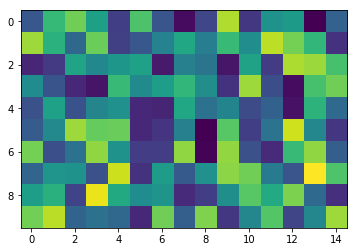

In [12]:
import matplotlib.pyplot as plt
imgplot = plt.imshow(result[0].reshape((10, 15)))
plt.show()

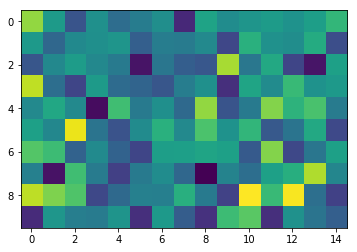

In [15]:
import matplotlib.pyplot as plt
import numpy as np
imgplot = plt.imshow(np.mean(result, axis=0).reshape((10, 15)))
plt.show()

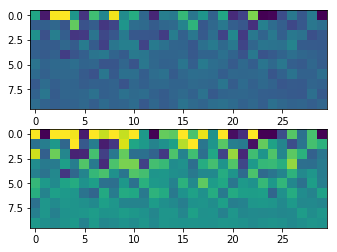

In [24]:
fig, ax = plt.subplots(2)

index = 100;
ax[0].imshow(digits[index].reshape((10, 30)));
ax[1].imshow(d.reconstr[index].reshape((10, 30)));

## Perform clustering with SSC

In [2]:
import numpy as np
from scipy.io import loadmat, savemat

mat = loadmat("./../1-helper/PCA/YaleB.mat")
labels = mat['Y'][0]

len(np.unique(labels))

37

In [5]:
from supporting_files.ji_zhang import err_rate
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import adjusted_rand_score as ari

#from sklearn.cluster import SpectralClustering
#ssc = SpectralClustering(k, n_jobs=-1)
#labels_pred = ssc.fit_predict(digits)
labels_pred = loadmat('./Labels_pred/YaleB.mat')['grps'][:, 0]

print("Accuracy: ", str(1-err_rate(labels, labels_pred)))
print("NMI: ", str(nmi(labels, labels_pred)))
print("ARI: ", str(ari(labels, labels_pred)))

Accuracy:  0.9970212765957447
NMI:  0.9959004222081838
ARI:  0.99374429201152
